In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
database_path = "Resources/hawaii.sqlite"
engine = sqlalchemy.create_engine(f"sqlite:///{database_path}")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
    # Find earliest date
    # Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date

'2017-08-23'

In [9]:
# Create a date time object to work out the earlier year
date_time_obj = dt.datetime.strptime(latest_date, '%Y-%m-%d') # %H:%M:%S.%f
date_time_obj.year

2017

In [10]:
# Find the last year
one_year_back = date_time_obj.year - 1
one_year_back

2016

In [11]:
# Reconstruct the date 12 months back from the latest available date
latest_twelve_months_date = dt.date(one_year_back, date_time_obj.month, date_time_obj.day)
latest_twelve_months_date

datetime.date(2016, 8, 23)

In [12]:
# Check which columns does the Measurement table has
# Try with inspect module
from sqlalchemy import inspect
inst = inspect(Measurement)
# Get columns' names from Measurement table
attr_names = [c_attr.key for c_attr in inst.mapper.column_attrs]
attr_names

['id', 'station', 'date', 'prcp', 'tobs']

In [13]:
# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date).\
    filter(Measurement.date > latest_twelve_months_date).\
    filter(Measurement.prcp != 'None').\
    all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_query, columns=['Date', 'Precipitation'])
prcp_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


In [15]:
## Sort the dataframe by date
# Set Date column as index
prcp_df.set_index('Date', inplace=True)

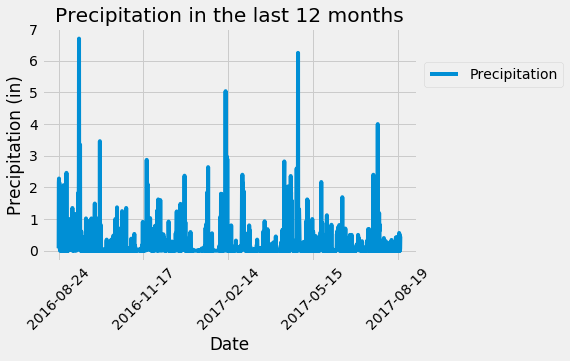

In [37]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=45)
plt.title("Precipitation in the last 12 months")
plt.ylabel("Precipitation (in)")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.8))
plt.savefig('Images/1_precipitation.png')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station.station).count()
print(f"There are total of {stations_count} stations.")

There are total of 9 stations.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
    # List the stations and the counts in descending order.
station = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Get ID of the most visited station from the query above
max_tobs_station = station[0][0]
max_tobs_station

'USC00519281'

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_with_max_tobs = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.station == max_tobs_station).all()
print(f"Station {max_tobs_station}:")
print(f"Min. Temp.    = {round(station_with_max_tobs[0][0], 1)}DegF")
print(f"Average Temp. = {round(station_with_max_tobs[0][1], 1)}DegF")
print(f"Max. Temp.    = {round(station_with_max_tobs[0][2], 1)}DegF")

Station USC00519281:
Min. Temp.    = 54.0DegF
Average Temp. = 71.7DegF
Max. Temp.    = 85.0DegF


In [22]:
# Choose the station with the highest number of temperature observations.
max_tobs_station_12_months_data = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == max_tobs_station).\
    filter(Measurement.date >= latest_twelve_months_date).all()
tobs_df = pd.DataFrame(max_tobs_station_12_months_data)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


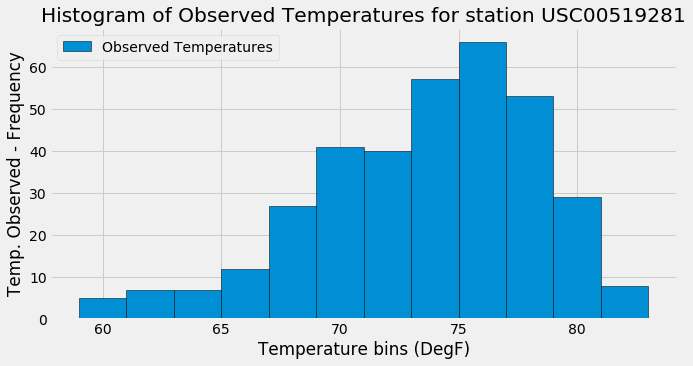

In [38]:
tobs_df.hist(bins=12, xrot=0, figsize=(10,5), ec="k")
plt.title(f"Histogram of Observed Temperatures for station {max_tobs_station}")
plt.xlabel("Temperature bins (DegF)")
plt.ylabel("Temp. Observed - Frequency")
labels= ["Observed Temperatures"]
plt.legend(labels=labels)
plt.savefig('Images/2_Histogram_Temp.png')
plt.show()

In [24]:
# Save the counts of the observations 
max_tobs_count_query = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).all()
    
    # Save the count of observations from the query results
max_count = 0
for i in range(len(max_tobs_count_query)):
    print(max_tobs_count_query[i][1])
    if max_tobs_count_query[i][1] > max_count:
        max_count = max_tobs_count_query[i][1]
    # return str(f"Maximum observations - {max_count}.")

1979
2709
2202
2612
1372
511
2772
2724
2669


## Bonus Challenge Assignment

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [32]:
# Plot the daily normals as an area plot with `stacked=False`
